#### Import the libraries

In [1]:
# For cleaning and preparing the dataset
# -> dataframe manipulation
# -> text manipulation
# -> Web Scrapping

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re

import random


# Module to serialize the content produced from the execution of the code

import pickle


# Module to monitor the progress of a python for loop

from tqdm import tqdm


# Module to manipulate text in python - NLTK package

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


# Module to compute word vectorizers and compute the cosine distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

#### Keras Text Classification (For creating the word embeddings)

In [2]:
from nltk.stem import WordNetLemmatizer

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from time import time

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.models import model_from_json
from keras.models import load_model

from tensorflow.python.keras.layers import Embedding, Flatten, Dense
from tensorflow.python.keras.models import Sequential

import matplotlib.pyplot as plt
from pylab import rcParams

Using TensorFlow backend.


In [3]:
# dataset_with_embeddings['Movie Title'][dataset_with_embeddings['Movie Title'] == 'Solo für 2'] = "All of Me"

# dataset_with_embeddings['Movie Title'][dataset_with_embeddings['Movie Title'] == 'Die letzte Metro'] = "The Last Metro"

# dataset_with_embeddings['Movie Title'][dataset_with_embeddings['Movie Title'] == 'Die letzte Metro'] = "The Last Metro"

In [4]:
# dataset_with_embeddings['Actors'][dataset_with_embeddings['Movie Title'] == 'heißblütig  kaltblütig']

#### Import the dataset

In [3]:
dataset = pd.read_pickle('dataset_part_2_07112019.pkl') # previous version "dataset_30102019.pkl"

dataset['Movie Title'][dataset['Movie Title'] == 'Das Geheimnis meines Erfolges'] = "The Secret of My Success"

dataset['Movie Title'][dataset['Movie Title'] == 'Alles unter Kontrolle - Keiner blickt durch'] = "Carry On Up the Khyber"

dataset['Movie Title'][dataset['Movie Title'] == 'Fire with Fire - Verbotene Leidenschaft'] = "Bed of Roses"

dataset['Movie Title'][dataset['Movie Title'] == 'Das Rosenbett'] = "Fire with Fire"

empty_list_tv = []

# On 07.11.2019 I noticed that some titles in my dataset had the words "TV-Mini Series" & "TV Movies" thus I decided to remove them

# In order for the change to take effect I should retrain the Keras Classifiers again!

for i in dataset['Movie Title']:
    if 'TV' in i: 
        empty_list_tv.append(i)
    else:
        pass

print("The number of the rows that are TV productions is: {}".format(len(empty_list_tv)))

print("\nThus, the 463 rows (movies) should be deleted since I don't want my algorithm to propose TV Series or TV Movies!")

dataset = dataset[~dataset['Movie Title'].isin(empty_list_tv)]

# Split the y variable ("Genres") to one hot encoded columns
mlb = MultiLabelBinarizer()
dataset = dataset.join(pd.DataFrame(mlb.fit_transform(dataset['Genres']),
                                    columns=mlb.classes_,
                                    index=dataset.index))

print("\nThe shape of the dataset that will be used in Keras classifier is: {}".format(dataset.shape))

dataset.head()

The number of the rows that are TV productions is: 463

Thus, the 463 rows (movies) should be deleted since I don't want my algorithm to propose TV Series or TV Movies!

The shape of the dataset that will be used in Keras classifier is: (10139, 37)


,Movie Title,IMDB Url,IMDB Rating,Actors,Director,Plot Summary,Plot Keywords,Genres,Combined_Features,Actors_Embeddings,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,7.8,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,A paraplegic Marine dispatched to the moon Pan...,"[avatar, future, marine, native, paraplegic]","[Action, Adventure, Fantasy]",avatar sam worthington zoe saldana sigourney w...,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,7.1,"[Johnny Depp, Geoffrey Rush, Orlando Bloom, Ke...",Gore Verbinski,Captain Barbossa Will Turner and Elizabeth Swa...,"[goddess, marriage, ceremony, marriage, propos...","[Action, Adventure, Fantasy]",pirates of the caribbean: at world's end johnn...,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",...,0,0,0,0,0,0,0,0,0,0
2,Spectre,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,6.8,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",Sam Mendes,A cryptic message from 007's past sends him pi...,"[bomb, espionage, sequel, spy, terrorist]","[Action, Adventure, Thriller]",spectre daniel craig christoph waltz léa seydo...,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...",...,0,0,0,0,0,0,0,1,0,0
3,The Dark Knight Rises,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,8.4,"[Christian Bale, Gary Oldman, Tom Hardy, Josep...",Christopher Nolan,Eight years after the Joker's reign of anarchy...,"[deception, imprisonment, lawlessness, police,...","[Action, Thriller]",the dark knight rises christian bale gary oldm...,"Christian Bale, Gary Oldman, Tom Hardy, Joseph...",...,0,0,0,0,0,0,0,1,0,0
4,John Carter,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,6.6,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...",Andrew Stanton,Transported to Barsoom a Civil War vet discove...,"[alien, american, civil, war, male, nipple, ma...","[Action, Adventure, Sci-Fi]",john carter taylor kitsch lynn collins samanth...,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...",...,0,0,0,1,0,0,0,0,0,0


#### Understand the dependent variable: Genres of each movie

The label of each Genre (one hot encoded):


   Action  Adult  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
0       1      0          1          0          0       0      0            0   
1       1      0          1          0          0       0      0            0   
2       1      0          1          0          0       0      0            0   
3       1      0          0          0          0       0      0            0   
4       1      0          1          0          0       0      0            0   

   Drama  Family  ...  News  Reality-TV  Romance  Sci-Fi  Short  Sport  \
0      0       0  ...     0           0        0       0      0      0   
1      0       0  ...     0           0        0       0      0      0   
2      0       0  ...     0           0        0       0      0      0   
3      0       0  ...     0           0        0       0      0      0   
4      0       0  ...     0           0        0       1      0      0   

   Talk-Show  Thriller 

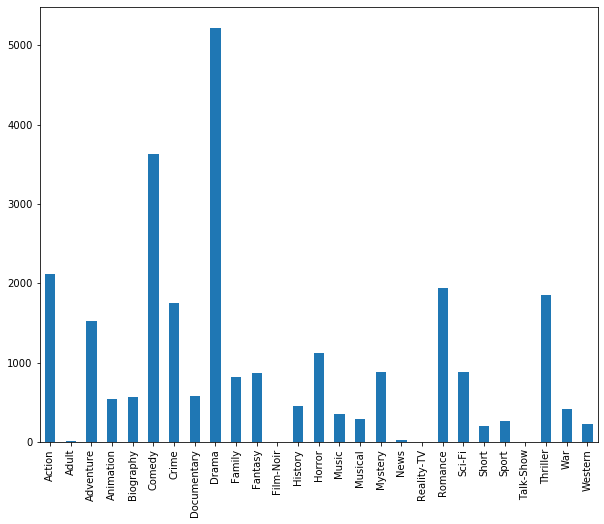

In [4]:
genre_labels = dataset[['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 
                        'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 
                        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']]

print("The label of each Genre (one hot encoded):")
print('\n')
print(genre_labels.head())

print("\n---------------------------------------------------------------------------------")

print('\nThe distribution of the genre labels (frequency plot)')
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 10

fig_size[1] = 8

plt.rcParams["figure.figsize"] = fig_size

genre_labels.sum(axis=0).plot.bar()

#### Pickle the unique genre tags for later use

In [20]:
# unique_genres = genre_labels.columns.tolist()

# len(unique_genres)

# with open('genres_list_10112019.pkl', 'wb') as f:
#     pickle.dump(unique_genres, f)

In [5]:
with open('genres_list_10112019.pkl', 'rb') as f:
    genres_list = pickle.load(f)

#### Create a random sequence of numbers to make predictions (used later)

In [6]:
random_numbers = random.sample(range(1, 2028), 5)

save_index_of_numbers = random_numbers

print("Randomly saved numbers to make predictions: {}".format(save_index_of_numbers))

Randomly saved numbers to make predictions: [851, 1672, 892, 875, 1793]


In [34]:
dataset.loc[:, 'clean_actors'] = actors_list

#### Model 1: Actors

In [110]:
# Class 1

class Keras_Configurations_model1():
    
        MAX_FEATURES = 20000
        BATCH_SIZE = 32
        NB_EPOCHS = 5
        EMB_DIMENSIONS = 100
        TARGET_LABELS = 27
        VERBOSE = 2
    
class Keras_Configurations_model2():
        
        MAX_FEATURES = 17500
        BATCH_SIZE = 32
        NB_EPOCHS = 5
        EMB_DIMENSIONS = 100
        TARGET_LABELS = 27
        VERBOSE = 2
        
class Keras_Configurations_model3():
        
        MAX_FEATURES = 20000
        BATCH_SIZE = 32
        NB_EPOCHS = 5
        EMB_DIMENSIONS = 100
        TARGET_LABELS = 27
        VERBOSE = 2

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Class 2

class Callback_Configurations():
    
    MONITOR_METRIC = 'val_loss'
    PATIENCE = 3
    VERBOSE = 1

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 1

def predict_genre_tags(indx, model):
    
    test_sequence = X_test_seq[indx:indx+1]
    
    text_prediction = model.predict(test_sequence)
    
    [float(i) for i in text_prediction[0]]
    
    tag_probabilities = text_prediction[0][np.argsort(text_prediction[0])[-3:]]
    
    indexes = np.argsort(text_prediction[0])[::-1][:3]

    predicted_tags = []
    
    for i, tag in enumerate(genres_list):
        if i in indexes:
            predicted_tags.append(genres_list[i])
    
    return predicted_tags

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 2

def inference_function(indx, model, x_test_seq, x_test, genres_list):
    
    test_sequence = x_test_seq[indx:indx+1]
    
    text_prediction = model.predict(test_sequence)
    
    [float(i) for i in text_prediction[0]]
    
    tag_probabilities = text_prediction[0][np.argsort(text_prediction[0])[-3:]]
    
    indexes = np.argsort(text_prediction[0])[::-1][:3]

    predicted_tags = []
    
    for i, tag in enumerate(genres_list):
        if i in indexes:
            predicted_tags.append(genres_list[i])
    
    return print('\n\nMovie Title: {}'.format(x_test['Movie Title'].iloc[indx]), '\n\nPredicted Genre labels: {}'.format(predicted_tags), '\n\nWith predicted probabilities: {}'.format(tag_probabilities), '\n\nThe actual Genre labels: {}'.format(x_test['Genres'].iloc[indx]), "\n\n", "---------------------------------------------------------------------------------------------------------")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 3

def preprocess_text(text):
    
    stop_words = set(stopwords.words('english'))
    
    lemmatizer = WordNetLemmatizer()
    
    no_stopword_text = [word for word in text.split(' ') if not word in stop_words]
    
    lemmatized_text = [lemmatizer.lemmatize(word, pos='v') for word in no_stopword_text]
    
    lowercase_text = [word.lower() for word in lemmatized_text]
    
    return ' '.join(lowercase_text)

def transform_actors(actors_column, dataset):
    
    actors_list = []

    for i in range(len(actors_column)):
        actors_list.append([element.lower() for element in actors_column.iloc[i]])

    dataset.loc[:, 'clean_actors'] = actors_list
    
    return print("The first line of the actors column to be used is:{}\n\n".format(dataset.loc[:, 'clean_actors'].iloc[0]))

def transform_plot(column_name):
    
    stop_words = set(stopwords.words('english'))

    lemmatizer = WordNetLemmatizer()
    
    dataset.loc[:, 'clean_plot_summary'] = dataset.loc[:, column_name].apply(lambda x: preprocess_text(x))
    
    print('\nThe first non-normalized line of the column Plot Summary: \n', dataset.loc[:, column_name].iloc[0])
    
    print('\nThe first normalized line of the column Plot Summary: \n', dataset.loc[:, 'clean_plot_summary'].iloc[0])

def transform_features(column_name):
    
    dataset.loc[:, 'clean_combined_features'] = dataset.loc[:, column_name].apply(lambda x: preprocess_text(x))

    print('\nThe first non-normalized line of the column Combined Features: \n', dataset.loc[:, column_name].iloc[0])
    
    print('\nThe first normalized line of the column Combined Features: \n', dataset.loc[:, 'clean_combined_features'].iloc[0])

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 4

def split_dataset(column_name, genre_labels, dataset):
    
    # clean_actors
    # clean_plot_summary
    # clean_combined_features
    
    X = dataset[['Movie Title', column_name, 'Genres']]
    y = genre_labels.values

    print("First value of variable X: {}\n\n".format(X.iloc[0]))

    print("First value of variable y: {}\n\n".format(y[0]))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    return X_train, X_test, y_train, y_test

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 5

def keras_tokenization(variable, x_train, x_test):
    
    if variable == "actors":

        actors_tokenizer = Tokenizer(num_words=Keras_Configurations_model1.MAX_FEATURES, lower=True, split=',', oov_token = '<OOV>')
    
        actors_tokenizer.fit_on_texts(list(x_train.loc[:, 'clean_actors']))

        actors_tokenizer.word_index = {e:i for e,i in actors_tokenizer.word_index.items() if i <= Keras_Configurations_model1.MAX_FEATURES}
    
        actors_tokenizer.word_index[actors_tokenizer.oov_token] = Keras_Configurations_model1.MAX_FEATURES + 1

        x_train.loc[:, 'actors_seqs'] = actors_tokenizer.texts_to_sequences(x_train.loc[:, 'clean_actors'])
    
        x_test.loc[:, 'actors_seqs'] = actors_tokenizer.texts_to_sequences(x_test.loc[:, 'clean_actors'])

        vocabulary_size_frequent_words = len(actors_tokenizer.word_index) + 1
        
        print("Data type of X_train is: {}\n".format(type(x_train)))
         
        print("Data type of X_test is: {}\n".format(type(x_test)))
    
        print('The number of most frequent actors is: {}\n'.format(vocabulary_size_frequent_words))
        
        tokenizer = actors_tokenizer
            
    elif variable == "plot":
        
        plot_tokenizer = Tokenizer(num_words=Keras_Configurations_model2.MAX_FEATURES, lower=True, split=' ', oov_token = '<OOV>')
        
        plot_tokenizer.fit_on_texts(list(x_train.loc[:, 'clean_plot_summary']))

        plot_tokenizer.word_index = {e:i for e,i in plot_tokenizer.word_index.items() if i <= Keras_Configurations_model2.MAX_FEATURES}
        
        plot_tokenizer.word_index[plot_tokenizer.oov_token] = Keras_Configurations_model2.MAX_FEATURES + 1

        x_train.loc[:, 'plot_summary_seqs'] = plot_tokenizer.texts_to_sequences(x_train.loc[:, 'clean_plot_summary'])
        
        x_test.loc[:, 'plot_summary_seqs'] = plot_tokenizer.texts_to_sequences(x_test.loc[:, 'clean_plot_summary'])

        vocabulary_size_frequent_words = len(plot_tokenizer.word_index) + 1
        
        print('The number of most frequent words is: {}\n'.format(vocabulary_size_frequent_words))
        
        tokenizer = plot_tokenizer
        
    elif variable == "features":
        
        combined_features_tokenizer = Tokenizer(num_words=Keras_Configurations_model3.MAX_FEATURES, lower=True, split=' ', oov_token = '<OOV>')
        
        combined_features_tokenizer.fit_on_texts(list(x_train.loc[:, 'clean_combined_features']))

        combined_features_tokenizer.word_index = {e:i for e,i in combined_features_tokenizer.word_index.items() if i <= Keras_Configurations_model3.MAX_FEATURES}
        
        combined_features_tokenizer.word_index[combined_features_tokenizer.oov_token] = Keras_Configurations_model3.MAX_FEATURES + 1

        x_train.loc[:, 'combined_features_seqs'] = combined_features_tokenizer.texts_to_sequences(x_train.loc[:, 'clean_combined_features'])
        
        x_test.loc[:, 'combined_features_seqs'] = combined_features_tokenizer.texts_to_sequences(x_test.loc[:, 'clean_combined_features'])

        vocabulary_size_frequent_words = len(combined_features_tokenizer.word_index) + 1
        
        print('The number of most frequent words is: {}\n'.format(vocabulary_size_frequent_words))
        
        tokenizer = combined_features_tokenizer
        
    return vocabulary_size_frequent_words, tokenizer

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 6

def padding_sequnce_length(variable, x_train):
    
    if variable == "actors":
    
        all_train_lengths =  list(x_train.actors_seqs.apply(len))

        maxlen = int(np.percentile(all_train_lengths, q=90))

        print('Max Length of the pad sequence: {}\n'.format(maxlen))
        
    elif variable == "plot":
        
        all_train_lengths = list(x_train.plot_summary_seqs.apply(len))

        maxlen = int(np.percentile(all_train_lengths, q=90))

        print('Max Length of each padding sequence: {}\n'.format(maxlen))
        
    elif variable == "features":
        
        all_train_lengths =  list(x_train.combined_features_seqs.apply(len))

        maxlen = int(np.percentile(all_train_lengths, q=90))

        print('Max Length of each padding sequence: {}\n'.format(maxlen))
        
    return maxlen

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 7

def padding_sequence(variable, x_train, x_test, y_train, y_test):
    
    if variable == "actors":
        
        x_train_seq = pad_sequences(x_train.loc[:, 'actors_seqs'], padding='post', maxlen=maxlen)
    
        x_test_seq = pad_sequences(x_test.loc[:, 'actors_seqs'], padding='post', maxlen=maxlen)

        print("An example of an X_train sequence of words:\n{}\n".format(x_train_seq[0]))
        print("An example of an X_test sequence of words:\n{}\n".format(x_test_seq[0]))

        print('X train shape: {}'.format(x_train_seq.shape))
        print('y train shape: {}\n'.format(y_train.shape))

        assert len(x_train_seq) == len(y_train)

        print('X test shape: {}'.format(x_test_seq.shape))
        print('y test shape: {}\n'.format(y_test.shape))

        assert len(x_test_seq) == len(y_test)
        
    elif variable == "plot":
        
        x_train_seq = pad_sequences(x_train.loc[:, 'plot_summary_seqs'], padding='post', maxlen=maxlen)
    
        x_test_seq = pad_sequences(x_test.loc[:, 'plot_summary_seqs'], padding='post', maxlen=maxlen)

        print("\n An example of an X_train sequence of words: {}".format(x_train_seq[0]))
        print("\n An example of an X_test sequence of words: {}".format(x_test_seq[0]))

        print('\nX train shape: {}'.format(x_train_seq.shape))
        print('y train shape: {}'.format(y_train.shape))

        assert len(x_train_seq) == len(y_train)

        print('\nX test shape: {}'.format(x_test_seq.shape))
        print('y test shape: {}'.format(y_test.shape))

        assert len(x_test_seq) == len(y_test)
        
    elif variable == "features":
        
        x_train_seq = pad_sequences(x_train.loc[:, 'combined_features_seqs'], padding='post', maxlen=maxlen)
    
        x_test_seq = pad_sequences(x_test.loc[:, 'combined_features_seqs'], padding='post', maxlen=maxlen)

        print("\n An example of an X_train sequence of words: {}\n".format(x_train_seq[0]))
        print("\n An example of an X_test sequence of words: {}\n".format(x_test_seq[0]))

        print('\nX train shape: {}'.format(x_train_seq.shape))
        print('y train shape: {}'.format(y_train.shape))

        assert len(x_train_seq) == len(y_train)

        print('\nX test shape: {}'.format(x_test_seq.shape))
        print('y test shape: {}'.format(y_test.shape))

        assert len(x_test_seq) == len(y_test)
        
    return x_train_seq, x_test_seq

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 8

def kera_classification_model(variable, vocab_size_frequent_words):
    
    if variable == "actors": 
    
        model = Sequential()

        model.add(Embedding(input_dim = vocab_size_frequent_words + 1,
                            output_dim = Keras_Configurations_model1.EMB_DIMENSIONS,
                            embeddings_initializer = 'uniform',
                            mask_zero = False,
                            input_length = maxlen))
 
        model.add(Flatten())

        model.add(Dense(Keras_Configurations_model1.BATCH_SIZE, activation='relu'))

        model.add(Dense(Keras_Configurations_model1.TARGET_LABELS, activation='sigmoid'))

        print(model.summary())

        model.compile(optimizer='adam', 
                      loss='binary_crossentropy',
                      metrics=['acc'])
        
    elif variable == "plot": 
    
        model = Sequential()

        model.add(Embedding(input_dim = vocab_size_frequent_words + 1,
                            output_dim = Keras_Configurations_model2.EMB_DIMENSIONS,
                            embeddings_initializer = 'uniform',
                            mask_zero = False,
                            input_length = maxlen))

        model.add(Flatten())

        model.add(Dense(Keras_Configurations_model2.BATCH_SIZE, activation='relu'))

        model.add(Dense(Keras_Configurations_model2.TARGET_LABELS, activation='sigmoid'))

        print(model.summary())

        model.compile(optimizer='adam', 
                      loss='binary_crossentropy',
                      metrics=['acc'])
        
    elif variable == "features": 
    
        model = Sequential()

        model.add(Embedding(input_dim = vocab_size_frequent_words + 1,
                            output_dim = Keras_Configurations_model3.EMB_DIMENSIONS,
                            embeddings_initializer = 'uniform',
                            mask_zero = False,
                            input_length = maxlen))

        model.add(Flatten())

        model.add(Dense(Keras_Configurations_model3.BATCH_SIZE, activation='relu'))

        model.add(Dense(Keras_Configurations_model3.TARGET_LABELS, activation='sigmoid'))

        print(model.summary())

        model.compile(optimizer='adam', 
                      loss='binary_crossentropy',
                      metrics=['acc'])
    return model
        
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 9

def callback(saved_model, model):
    
    weights_fname = '{}'.format(saved_model)
    
    # C:\\Users\\spano\\Desktop\\GitHub-Thesis\\keras_models\\{}

    try:
        model.load_weights(weights_fname)
    except:
        print('\nPre-trained weights not found. Fitting from start')
        pass

    monitor_metric = Callback_Configurations.MONITOR_METRIC
    
    callbacks = [
        EarlyStopping(monitor=monitor_metric,
                      patience=Callback_Configurations.PATIENCE,
                      verbose=Callback_Configurations.VERBOSE,
                      restore_best_weights=True),

        ModelCheckpoint(filepath=weights_fname,
                        monitor=monitor_metric,
                        verbose=Callback_Configurations.VERBOSE,
                        save_best_only=True,
                        save_weights_only=True)
]
    return callbacks

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 10

def fit_keras(variable, model, x_train_seq, y_train, x_test_seq, y_test):

    if variable == "actors":
        
        s = time()

        fit_model = model.fit(x_train_seq, y_train, 
                              epochs=Keras_Configurations_model1.NB_EPOCHS,
                              verbose = Keras_Configurations_model1.VERBOSE,
                              batch_size=Keras_Configurations_model1.BATCH_SIZE,
                              validation_data=(x_test_seq, y_test),
                              callbacks=callbacks)

        duration = time() - s
        print("\nTraining time finished. Duration {} secs".format(duration))

    elif variable == "plot":
        
        s = time()

        fit_model = model.fit(x_train_seq, y_train, 
                              epochs=Keras_Configurations_model2.NB_EPOCHS,
                              verbose = Keras_Configurations_model2.VERBOSE,
                              batch_size=Keras_Configurations_model2.BATCH_SIZE,
                              validation_data=(x_test_seq, y_test),
                              callbacks=callbacks)

        duration = time() - s
        print("\nTraining time finished. Duration {} secs".format(duration))
        
    elif variable == "features":
        
        s = time()

        fit_model = model.fit(x_train_seq, y_train, 
                              epochs=Keras_Configurations_model2.NB_EPOCHS,
                              verbose = Keras_Configurations_model2.VERBOSE,
                              batch_size=Keras_Configurations_model2.BATCH_SIZE,
                              validation_data=(x_test_seq, y_test),
                              callbacks=callbacks)

        duration = time() - s
        print("\nTraining time finished. Duration {} secs".format(duration))
    
    return fit_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 11

def save_model(model, model_name):
    
    # model_cast
    # model_plot
    # model_combined_features
    
    model_json = model.to_json()

    with open("{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)

    model.save_weights("{}.h5".format(model_name))
    
    print("\nModel's weights are saved")
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 12

def extract_word_embeddings(variable, model, tokenizer):
    
    embeddings = model.layers[0].get_weights()[0]
    
    if variable == "actors":

        word_embeddings = {w:embeddings[idx] for w, idx in tokenizer.word_index.items() if idx <= Keras_Configurations_model1.MAX_FEATURES+1}
    
        print("\nThe word embedding vector of the actor 'Johnny Depp' is:\n\n", word_embeddings['johnny depp'])
    
    elif variable == "plot":

        word_embeddings = {w:embeddings[idx] for w, idx in tokenizer.word_index.items() if idx <= Keras_Configurations_model2.MAX_FEATURES+1}
    
        print("\nThe word embedding vector of the word 'marin' is:\n\n", word_embeddings['marine'])
        
    elif variable == "features":

        word_embeddings = {w:embeddings[idx] for w, idx in tokenizer.word_index.items() if idx <= Keras_Configurations_model3.MAX_FEATURES+1}
    
        print("\nThe word embedding vector of the word 'spectre' is:\n\n", word_embeddings['spectre'])
        
    return word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 13

def assign_word_embeddings(variable, dataset, word_embeddings):
    
    if variable == "actors":
    
        average_vector_list_cast = []

        min_vector_list_cast = []

        max_vector_list_cast = []

        actors_embeddings_list = []

        for i in tqdm(range(len(dataset.index))):
            
            actors = dataset.loc[:, "clean_actors"].iloc[i]
    
            assert [word.islower() for word in actors] # assert that all actors are present in lower case
    
            actors_embeddings_list.append([word_embeddings[word] if word in word_embeddings else word_embeddings['<OOV>'] for word in actors])
    
        dataset.loc[:, 'actors_embeddings_list'] = actors_embeddings_list

        for i in tqdm(range(len(dataset.index))):
            
            actor_embeddings = dataset["actors_embeddings_list"].iloc[i]
    
            minimum = np.min([element for element in actor_embeddings], axis=0)
            maximum = np.max([element for element in actor_embeddings], axis=0)
            average = np.mean([element for element in actor_embeddings], axis=0)
    
            min_vector_list_cast.append(minimum)
            max_vector_list_cast.append(maximum)
            average_vector_list_cast.append(average)

        dataset['minimum_cast_vectors'] = min_vector_list_cast
        dataset['maximum_cast_vectors'] = max_vector_list_cast
        dataset['average_cast_vectors'] = average_vector_list_cast
        
    elif variable == "plot":
    
        average_vector_list_plot = []

        min_vector_list_plot = []

        max_vector_list_plot = []

        plot_embeddings_list = []

        for i in tqdm(range(len(dataset.index))):
            
            plot = dataset["clean_plot_summary"].iloc[i]
    
            plot_split = plot.split(' ')
    
            assert [word.islower() for word in plot_split]
    
            plot_embeddings_list.append([word_embeddings[word] if word in word_embeddings else word_embeddings['<OOV>'] for word in plot_split])
    
        dataset['plot_embeddings_list'] = plot_embeddings_list

        for i in tqdm(range(len(dataset.index))):
            
            plot_embeddings = dataset["plot_embeddings_list"].iloc[i]
    
            minimum = np.min([element for element in plot_embeddings], axis=0)
            maximum = np.max([element for element in plot_embeddings], axis=0)
            average = np.mean([element for element in plot_embeddings], axis=0)
    
            min_vector_list_plot.append(minimum)
            max_vector_list_plot.append(maximum)
            average_vector_list_plot.append(average)

        dataset['minimum_plot_vectors'] = min_vector_list_plot
        dataset['maximum_plot_vectors'] = max_vector_list_plot
        dataset['average_plot_vectors'] = average_vector_list_plot
        
    elif variable == "features":
    
        average_vector_list_combined_features = []

        min_vector_list_combined_features = []

        max_vector_list_combined_features = []

        combined_features_embeddings_list = []

        for i in tqdm(range(len(dataset.index))):
    
            combined_features = dataset["clean_combined_features"].iloc[i]
    
            combined_features_split = combined_features.split(' ')
    
            assert [word.islower() for word in combined_features_split]
    
            combined_features_embeddings_list.append([word_embeddings[word] if word in word_embeddings else word_embeddings['<OOV>'] for word in combined_features_split])
    
        dataset['combined_features_embeddings_list'] = combined_features_embeddings_list

        for i in tqdm(range(len(dataset.index))):
            
            combined_features_embeddings = dataset["combined_features_embeddings_list"].iloc[i]
    
            minimum = np.min([element for element in combined_features_embeddings], axis=0)
            maximum = np.max([element for element in combined_features_embeddings], axis=0)
            average = np.mean([element for element in combined_features_embeddings], axis=0)
    
            min_vector_list_combined_features.append(minimum)
            max_vector_list_combined_features.append(maximum)
            average_vector_list_combined_features.append(average)

        dataset['minimum_combined_features_vectors'] = min_vector_list_combined_features
        dataset['maximum_combined_features_vectors'] = max_vector_list_combined_features
        dataset['average_combined_features_vectors'] = average_vector_list_combined_features
        
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 14

def evaluate_keras_model(model, x_test_seq, y_test):
    
    score = model.evaluate(x_test_seq, y_test, verbose=0)

    print('\nTest Score:', score[0])

    print('\nTest Accuracy:', score[1])
    
    return score

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 15

def plot_model_metrics(fit_model):

    rcParams['figure.figsize'] = 10, 5

    plt.plot(fit_model.history['acc'] , 'g')
    plt.plot(fit_model.history['val_acc'] , 'b')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

    rcParams['figure.figsize'] = 10, 5

    plt.plot(fit_model.history['loss'] , 'g')
    plt.plot(fit_model.history['val_loss'] , 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

---------------------------------------------------------------------------------

Transfrom the column of the actors

The first line of the actors column to be used is:['sam worthington', 'zoe saldana', 'sigourney weaver', 'stephen lang', 'michelle rodriguez', 'giovanni ribisi', 'joel david moore', 'cch pounder', 'wes studi', 'laz alonso', 'dileep rao', 'matt gerald', 'sean anthony moran', 'jason whyte', 'scott lawrence']



---------------------------------------------------------------------------------

Split the dataset into train & validation set

First value of variable X: Movie Title                                                Avatar
clean_actors    [sam worthington, zoe saldana, sigourney weave...
Genres                               [Action, Adventure, Fantasy]
Name: 0, dtype: object


First value of variable y: [1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



---------------------------------------------------------------------------------

Tokenize the dataset 

100%|██████████████████████████████████████████████████████████████████████████| 10139/10139 [00:01<00:00, 6644.17it/s]



---------------------------------------------------------------------------------
Evaluate the classification model

Test Score: 0.2673106263786613

Test Accuracy: 0.91705

---------------------------------------------------------------------------------

Plot the model's accuracy & loss


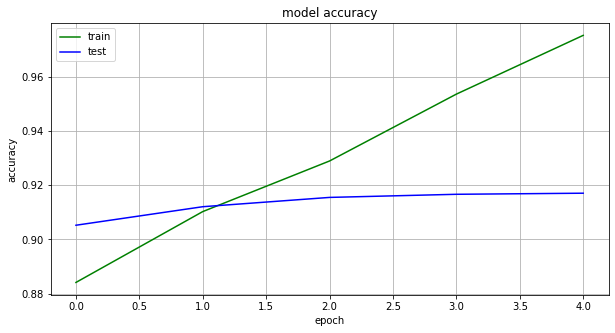

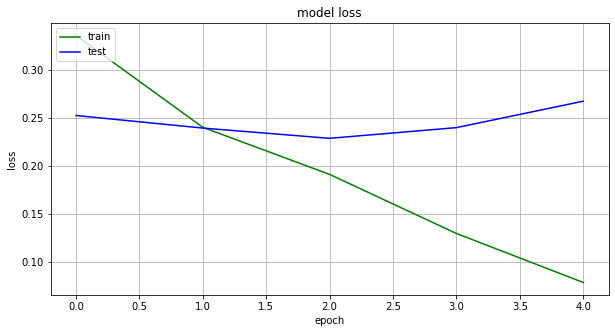


---------------------------------------------------------------------------------

Predict the genre tags of new movie's actors


Movie Title: That's Dancing! 

Predicted Genre labels: ['Comedy', 'Drama', 'Family'] 

With predicted probabilities: [0.08907136 0.18332359 0.18406257] 

The actual Genre labels: ['Documentary', 'Musical'] 

 ---------------------------------------------------------------------------------------------------------


Movie Title: Produktionsdagbog: Prag - Berlin - København (Video 2008) 

Predicted Genre labels: ['Drama', 'Horror', 'Thriller'] 

With predicted probabilities: [0.19944644 0.2411696  0.52606374] 

The actual Genre labels: ['Documentary'] 

 ---------------------------------------------------------------------------------------------------------


Movie Title: Der Tod kommt auf vier Pfoten 

Predicted Genre labels: ['Action', 'Adventure', 'Sci-Fi'] 

With predicted probabilities: [0.2528054  0.42611584 0.55862224] 

The actual Genre labels: ['Com

In [98]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Transfrom the column of the actors
print("---------------------------------------------------------------------------------\n")
print("Transfrom the column of the actors\n")

transform_actors(dataset.loc[:, "Actors"], dataset) # function 3: transform_actors

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Split the dataset into train & validation set
print("\n---------------------------------------------------------------------------------")
print("\nSplit the dataset into train & validation set\n")

X_train, X_test, y_train, y_test = split_dataset('clean_actors', genre_labels, dataset) # function 4: split_dataset

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Tokenize the dataset (using the keras tokenizer)
print("\n---------------------------------------------------------------------------------")
print("\nTokenize the dataset (using the keras tokenizer)\n")

vocabulary_size_frequent_words, tokenizer = keras_tokenization("actors", X_train, X_test) # function 5: keras_tokenization

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Specify the length of the maxlen variable
print("\n---------------------------------------------------------------------------------")
print("\nSpecify the length of the maxlen variable (length is a parameter for the optimal padding execution)\n")

maxlen = padding_sequnce_length("actors", X_train) # function 6: padding_sequnce_length

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Create the padding sequence of texts
print("\n---------------------------------------------------------------------------------")
print("\nCreate the padding sequence of texts\n")

X_train_seq, X_test_seq = padding_sequence("actors", X_train, X_test, y_train, y_test) # function 7: padding_sequence

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Setting the Keras Classification Model
print("\n---------------------------------------------------------------------------------")
print("\nCreate the Keras Classification Model\n")

model_1 = kera_classification_model("actors", vocabulary_size_frequent_words) # function 8: kera_classification_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Creating a callback function to save the model when a better validation loss is achieved
print("\n---------------------------------------------------------------------------------")
print("\nEnsemble a callback function")  # function 9: callback

callbacks = callback("model_cast.h5", model_1)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Fitting the Keras classification model on the train dataset
print("\n---------------------------------------------------------------------------------")
print("\nFit the keras classification model")

fit_model = fit_keras("actors", model_1, X_train_seq, y_train, X_test_seq, y_test) # function 10: fit_keras

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Save the trained model
print("\n---------------------------------------------------------------------------------")
print("\nSave the Model")

save_model(model_1, "model_cast") # function 11: save_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Extract the word embeddings of the actors
print("\n---------------------------------------------------------------------------------")
print("\nExtract the word embeddings")

word_embeddings = extract_word_embeddings("actors", model_1, tokenizer) # function 12: extract_word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Assign the word embeddings to each different actor
print("\n---------------------------------------------------------------------------------")
print("\nAssign the word embeddings to each different actor")

assign_word_embeddings("actors", dataset, word_embeddings) # function 13: assign_word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Evaluate the model
print("\n---------------------------------------------------------------------------------")
print("Evaluate the classification model")

score = evaluate_keras_model(model_1, X_test_seq, y_test) # function 14: evaluate_keras_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Plot keras model accuracy & loss
print("\n---------------------------------------------------------------------------------")
print("\nPlot the model's accuracy & loss")

plot_model_metrics(fit_model) # function 15: plot_model_metrics

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Predict the genre tags on new data
print("\n---------------------------------------------------------------------------------")
print("\nPredict the genre tags of new movie's actors")

for i in save_index_of_numbers:
    inference_function(i, model_1, X_test_seq, X_test, genres_list) # function 2: inference_function

#### Solve this with professor! (dataframe pivoting)

In [99]:
df_scores = pd.DataFrame({'Keras Model':pd.Series(['Actors'], dtype='str'),
                         'Test Loss':pd.Series([score[0]], dtype='float'),
                         'Test Accuracy':pd.Series([score[1]], dtype='float')})

df_scores

,Keras Model,Test Loss,Test Accuracy
0,Actors,0.267311,0.91705


In [100]:
df_predictions = pd.DataFrame({'Movie Title':pd.Series([X_test['Movie Title'].iloc[save_index_of_numbers[0]]], dtype='str'),
                               'Predicted Genre tags':pd.Series([predict_genre_tags(save_index_of_numbers[0], model_1)], dtype='str'),
                               'Real Genre tags':pd.Series([X_test['Genres'].iloc[save_index_of_numbers[0]]], dtype='str')})

for i in range(len(save_index_of_numbers[0:])):

    df_predictions = df_predictions.append({'Movie Title' : X_test['Movie Title'].iloc[save_index_of_numbers[i]], 
                                            'Predicted Genre tags' : predict_genre_tags(save_index_of_numbers[i], model_1),
                                            'Real Genre tags': X_test['Genres'].iloc[save_index_of_numbers[i]]} , ignore_index=True)

df_predictions.drop(df_predictions.index[0])

,Movie Title,Predicted Genre tags,Real Genre tags
1,That's Dancing!,"[Comedy, Drama, Family]","[Documentary, Musical]"
2,Produktionsdagbog: Prag - Berlin - København (...,"[Drama, Horror, Thriller]",[Documentary]
3,Der Tod kommt auf vier Pfoten,"[Action, Adventure, Sci-Fi]","[Comedy, Horror, Sci-Fi, Thriller]"
4,xXx: State of the Union,"[Action, Crime, Drama]","[Action, Adventure, Crime]"
5,Der Gendarm von St. Tropez,"[Comedy, Crime, Drama]","[Adventure, Comedy, Crime]"


#### Model 2: Plot Summary

---------------------------------------------------------------------------------

Transfrom the column of the actors


The first non-normalized line of the column Plot Summary: 
 A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes torn between following his orders and protecting the world he feels is his home

The first normalized line of the column Plot Summary: 
 a paraplegic marine dispatch moon pandora unique mission become tear follow order protect world feel home

---------------------------------------------------------------------------------

Split the dataset into train & validation set

First value of variable X: Movie Title                                                      Avatar
clean_plot_summary    a paraplegic marine dispatch moon pandora uniq...
Genres                                     [Action, Adventure, Fantasy]
Name: 0, dtype: object


First value of variable y: [1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



-------------

100%|██████████████████████████████████████████████████████████████████████████| 10139/10139 [00:01<00:00, 8435.08it/s]



---------------------------------------------------------------------------------
Evaluate the classification model

Test Score: 0.2530621550903753

Test Accuracy: 0.9176164

---------------------------------------------------------------------------------

Plot the model's accuracy & loss


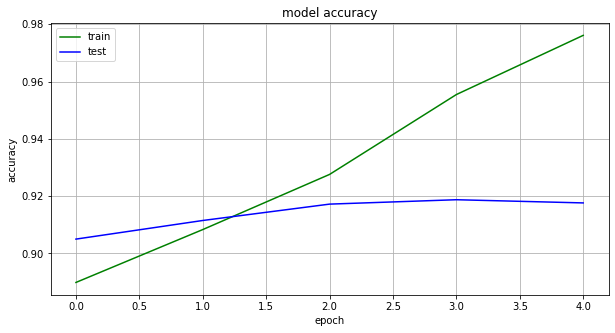

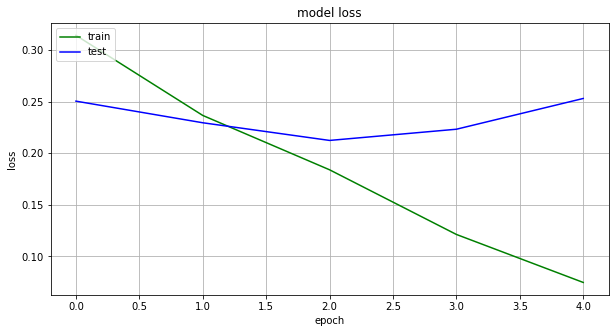


---------------------------------------------------------------------------------

Predict the genre tags of new movie's actors


Movie Title: That's Dancing! 

Predicted Genre labels: ['Biography', 'Documentary', 'Music'] 

With predicted probabilities: [0.24188107 0.27237096 0.9111504 ] 

The actual Genre labels: ['Documentary', 'Musical'] 

 ---------------------------------------------------------------------------------------------------------


Movie Title: Produktionsdagbog: Prag - Berlin - København (Video 2008) 

Predicted Genre labels: ['Comedy', 'Documentary', 'Short'] 

With predicted probabilities: [0.18635419 0.2866174  0.3144101 ] 

The actual Genre labels: ['Documentary'] 

 ---------------------------------------------------------------------------------------------------------


Movie Title: Der Tod kommt auf vier Pfoten 

Predicted Genre labels: ['Action', 'Horror', 'Sci-Fi'] 

With predicted probabilities: [0.5694544  0.63568455 0.8346839 ] 

The actual Genre label

In [105]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Transfrom the column of the plot_summary
print("---------------------------------------------------------------------------------\n")
print("Transfrom the column of the plot_summary\n")

transform_plot("Plot Summary") # function 3: transform_plot

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Split the dataset into train & validation set
print("\n---------------------------------------------------------------------------------")
print("\nSplit the dataset into train & validation set\n")

X_train, X_test, y_train, y_test = split_dataset('clean_plot_summary', genre_labels, dataset) # function 4: split_dataset

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Tokenize the dataset (using the keras tokenizer)
print("\n---------------------------------------------------------------------------------")
print("\nTokenize the dataset (using the keras tokenizer)\n")

vocabulary_size_frequent_words, tokenizer = keras_tokenization("plot", X_train, X_test) # function 5: keras_tokenization

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Specify the length of the maxlen variable
print("\n---------------------------------------------------------------------------------")
print("\nSpecify the length of the maxlen variable (length is a parameter for the optimal padding execution)\n")

maxlen = padding_sequnce_length("plot", X_train) # function 6: padding_sequnce_length

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Create the padding sequence of texts
print("\n---------------------------------------------------------------------------------")
print("\nCreate the padding sequence of texts\n")

X_train_seq, X_test_seq = padding_sequence("plot", X_train, X_test, y_train, y_test) # function 7: padding_sequence

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Setting the Keras Classification Model
print("\n---------------------------------------------------------------------------------")
print("\nCreate the Keras Classification Model\n")

model_2 = kera_classification_model("plot", vocabulary_size_frequent_words) # function 8: kera_classification_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Creating a callback function to save the model when a better validation loss is achieved
print("\n---------------------------------------------------------------------------------")
print("\nEnsemble a callback function")  # function 9: callback

callbacks = callback("model_plot.h5", model_2)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Fitting the Keras classification model on the train dataset
print("\n---------------------------------------------------------------------------------")
print("\nFit the keras classification model")

fit_model = fit_keras("plot", model_2, X_train_seq, y_train, X_test_seq, y_test) # function 10: fit_keras

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Save the trained model
print("\n---------------------------------------------------------------------------------")
print("\nSave the Model")

save_model(model_2, "model_plot") # function 11: save_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Extract the word embeddings of the plot_summary
print("\n---------------------------------------------------------------------------------")
print("\nExtract the word embeddings")

word_embeddings = extract_word_embeddings("plot", model_2, tokenizer) # function 12: extract_word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Assign the word embeddings to each different actor
print("\n---------------------------------------------------------------------------------")
print("\nAssign the word embeddings to each different actor")

assign_word_embeddings("plot", dataset, word_embeddings) # function 13: assign_word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Evaluate the model
print("\n---------------------------------------------------------------------------------")
print("Evaluate the classification model")

score = evaluate_keras_model(model_2, X_test_seq, y_test) # function 14: evaluate_keras_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Plot keras model accuracy & loss
print("\n---------------------------------------------------------------------------------")
print("\nPlot the model's accuracy & loss")

plot_model_metrics(fit_model) # function 15: plot_model_metrics

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Predict the genre tags on new data
print("\n---------------------------------------------------------------------------------")
print("\nPredict the genre tags of new movie's plot_summary")

for i in save_index_of_numbers:
    inference_function(i, model_2, X_test_seq, X_test, genres_list) # function 2: inference_function

#### Test-Accuracy Dataframe

In [106]:
df_scores = pd.DataFrame({'Keras Model':pd.Series(['Plot Summary'], dtype='str'),
                         'Test Loss':pd.Series([score[0]], dtype='float'),
                         'Test Accuracy':pd.Series([score[1]], dtype='float')})

df_scores

,Keras Model,Test Loss,Test Accuracy
0,Plot Summary,0.253062,0.917616


#### Predicted vsActual Genre Tags

In [108]:
df_predictions = pd.DataFrame({'Movie Title':pd.Series([X_test['Movie Title'].iloc[save_index_of_numbers[0]]], dtype='str'),
                               'Predicted Genre tags':pd.Series([predict_genre_tags(save_index_of_numbers[0], model_2)], dtype='str'),
                               'Real Genre tags':pd.Series([X_test['Genres'].iloc[save_index_of_numbers[0]]], dtype='str')})

for i in range(len(save_index_of_numbers[0:])):

    df_predictions = df_predictions.append({'Movie Title' : X_test['Movie Title'].iloc[save_index_of_numbers[i]], 
                                            'Predicted Genre tags' : predict_genre_tags(save_index_of_numbers[i], model_2),
                                            'Real Genre tags': X_test['Genres'].iloc[save_index_of_numbers[i]]} , ignore_index=True)

df_predictions.drop(df_predictions.index[0])

,Movie Title,Predicted Genre tags,Real Genre tags
1,That's Dancing!,"[Biography, Documentary, Music]","[Documentary, Musical]"
2,Produktionsdagbog: Prag - Berlin - København (...,"[Comedy, Documentary, Short]",[Documentary]
3,Der Tod kommt auf vier Pfoten,"[Action, Horror, Sci-Fi]","[Comedy, Horror, Sci-Fi, Thriller]"
4,xXx: State of the Union,"[Action, Adventure, Comedy]","[Action, Adventure, Crime]"
5,Der Gendarm von St. Tropez,"[Comedy, Crime, Drama]","[Adventure, Comedy, Crime]"


#### Model 3: Combined Features

---------------------------------------------------------------------------------

Transfrom the column of the combined_features


The first non-normalized line of the column Combined Features: 
 avatar sam worthington zoe saldana sigourney weaver stephen lang michelle rodriguez giovanni ribisi joel david moore cch pounder wes studi laz alonso dileep rao matt gerald sean anthony moran jason whyte scott lawrence james cameron a paraplegic marine dispatched to the moon pandora on a unique mission becomes torn between following his orders and protecting the world he feels is his home avatar future marine native paraplegic action adventure fantasy

The first normalized line of the column Combined Features: 
 avatar sam worthington zoe saldana sigourney weaver stephen lang michelle rodriguez giovanni ribisi joel david moore cch pounder wes studi laz alonso dileep rao matt gerald sean anthony moran jason whyte scott lawrence jam cameron paraplegic marine dispatch moon pandora unique mission 

100%|██████████████████████████████████████████████████████████████████████████| 10139/10139 [00:02<00:00, 5011.88it/s]



---------------------------------------------------------------------------------
Evaluate the classification model

Test Score: 0.06875653023403543

Test Accuracy: 0.9796369

---------------------------------------------------------------------------------

Plot the model's accuracy & loss


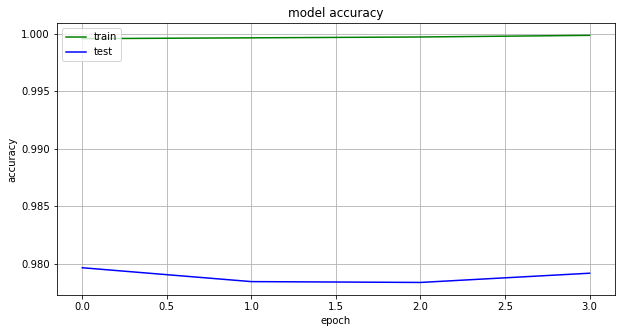

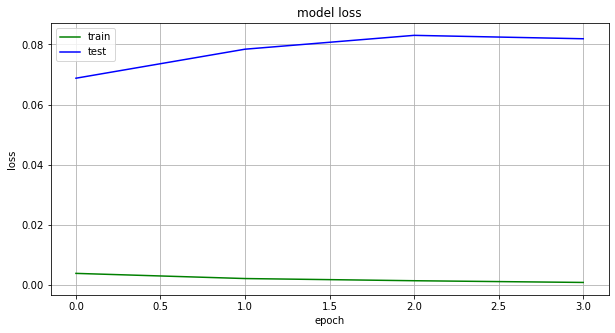


---------------------------------------------------------------------------------

Predict the genre tags of new movie's combined_features


Movie Title: That's Dancing! 

Predicted Genre labels: ['Documentary', 'Musical', 'Sport'] 

With predicted probabilities: [0.03396851 0.03490967 0.92308474] 

The actual Genre labels: ['Documentary', 'Musical'] 

 ---------------------------------------------------------------------------------------------------------


Movie Title: Produktionsdagbog: Prag - Berlin - København (Video 2008) 

Predicted Genre labels: ['Comedy', 'Documentary', 'Short'] 

With predicted probabilities: [0.03288487 0.39715442 0.6411362 ] 

The actual Genre labels: ['Documentary'] 

 ---------------------------------------------------------------------------------------------------------


Movie Title: Der Tod kommt auf vier Pfoten 

Predicted Genre labels: ['Comedy', 'Sci-Fi', 'Thriller'] 

With predicted probabilities: [0.55306345 0.94012314 0.9877996 ] 

The actual 

In [111]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Transfrom the column of the combined features
print("---------------------------------------------------------------------------------\n")
print("Transfrom the column of the combined_features\n")

transform_features("Combined_Features") # function 3: transform_features

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Split the dataset into train & validation set
print("\n---------------------------------------------------------------------------------")
print("\nSplit the dataset into train & validation set\n")

X_train, X_test, y_train, y_test = split_dataset('clean_combined_features', genre_labels, dataset) # function 4: split_dataset

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Tokenize the dataset (using the keras tokenizer)
print("\n---------------------------------------------------------------------------------")
print("\nTokenize the dataset (using the keras tokenizer)\n")

vocabulary_size_frequent_words, tokenizer = keras_tokenization("features", X_train, X_test) # function 5: keras_tokenization

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Specify the length of the maxlen variable
print("\n---------------------------------------------------------------------------------")
print("\nSpecify the length of the maxlen variable (length is a parameter for the optimal padding execution)\n")

maxlen = padding_sequnce_length("features", X_train) # function 6: padding_sequnce_length

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Create the padding sequence of texts
print("\n---------------------------------------------------------------------------------")
print("\nCreate the padding sequence of texts\n")

X_train_seq, X_test_seq = padding_sequence("features", X_train, X_test, y_train, y_test) # function 7: padding_sequence

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Setting the Keras Classification Model
print("\n---------------------------------------------------------------------------------")
print("\nCreate the Keras Classification Model\n")

model_3 = kera_classification_model("features", vocabulary_size_frequent_words) # function 8: kera_classification_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Creating a callback function to save the model when a better validation loss is achieved
print("\n---------------------------------------------------------------------------------")
print("\nEnsemble a callback function")  # function 9: callback

callbacks = callback("model_combined_features.h5", model_3)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Fitting the Keras classification model on the train dataset
print("\n---------------------------------------------------------------------------------")
print("\nFit the keras classification model")

fit_model = fit_keras("features", model_3, X_train_seq, y_train, X_test_seq, y_test) # function 10: fit_keras

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Save the trained model
print("\n---------------------------------------------------------------------------------")
print("\nSave the Model")

save_model(model_3, "model_combined_features") # function 11: save_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Extract the word embeddings of the combined_features
print("\n---------------------------------------------------------------------------------")
print("\nExtract the word embeddings")

word_embeddings = extract_word_embeddings("features", model_3, tokenizer) # function 12: extract_word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Assign the word embeddings to each different actor
print("\n---------------------------------------------------------------------------------")
print("\nAssign the word embeddings to each different actor")

assign_word_embeddings("features", dataset, word_embeddings) # function 13: assign_word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Evaluate the model
print("\n---------------------------------------------------------------------------------")
print("Evaluate the classification model")

score = evaluate_keras_model(model_3, X_test_seq, y_test) # function 14: evaluate_keras_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Plot keras model accuracy & loss
print("\n---------------------------------------------------------------------------------")
print("\nPlot the model's accuracy & loss")

plot_model_metrics(fit_model) # function 15: plot_model_metrics

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Predict the genre tags on new data
print("\n---------------------------------------------------------------------------------")
print("\nPredict the genre tags of new movie's combined_features")

for i in save_index_of_numbers:
    inference_function(i, model_3, X_test_seq, X_test, genres_list) # function 2: inference_function

#### Test-Accuracy Dataframe

In [112]:
df_scores = pd.DataFrame({'Keras Model':pd.Series(['Combined Features'], dtype='str'),
                         'Test Loss':pd.Series([score[0]], dtype='float'),
                         'Test Accuracy':pd.Series([score[1]], dtype='float')})

df_scores

,Keras Model,Test Loss,Test Accuracy
0,Combined Features,0.068757,0.979637


#### Predicted vs Actual Genre Tags

In [113]:
df_predictions = pd.DataFrame({'Movie Title':pd.Series([X_test['Movie Title'].iloc[save_index_of_numbers[0]]], dtype='str'),
                               'Predicted Genre tags':pd.Series([predict_genre_tags(save_index_of_numbers[0], model_3)], dtype='str'),
                               'Real Genre tags':pd.Series([X_test['Genres'].iloc[save_index_of_numbers[0]]], dtype='str')})

for i in range(len(save_index_of_numbers[0:])):

    df_predictions = df_predictions.append({'Movie Title' : X_test['Movie Title'].iloc[save_index_of_numbers[i]], 
                                            'Predicted Genre tags' : predict_genre_tags(save_index_of_numbers[i], model_3),
                                            'Real Genre tags': X_test['Genres'].iloc[save_index_of_numbers[i]]} , ignore_index=True)

df_predictions.drop(df_predictions.index[0])

,Movie Title,Predicted Genre tags,Real Genre tags
1,That's Dancing!,"[Documentary, Musical, Sport]","[Documentary, Musical]"
2,Produktionsdagbog: Prag - Berlin - København (...,"[Comedy, Documentary, Short]",[Documentary]
3,Der Tod kommt auf vier Pfoten,"[Comedy, Sci-Fi, Thriller]","[Comedy, Horror, Sci-Fi, Thriller]"
4,xXx: State of the Union,"[Action, Adventure, Crime]","[Action, Adventure, Crime]"
5,Der Gendarm von St. Tropez,"[Adventure, Comedy, Crime]","[Adventure, Comedy, Crime]"


In [ ]:
# Ask Louridas about this! 
# Fit on sequences does work properly


# def predict_the_genre_labels(text, indx):
#     text = preprocess_text(text)
    
#     print(text)
    
#     print(type(text))

#     combined_features_tokenizer.fit_on_texts(text)
    
#     text_sequence= combined_features_tokenizer.texts_to_sequences(text)
    
#     print('\n', text_sequence)
    
#     print("\nLength of the sequence: {}".format(len(text_sequence)))
    
#     text_sequence_padding = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
    
#     print('\n', text_sequence_padding[0])
    
#     print("\nLength of the sequence: {}".format(len(text_sequence_padding)))
    
#     text_prediction = model_3.predict(text_sequence)
    
#     [float(i) for i in text_prediction[0]]

#     indexes = np.argsort(prediction[0])[::-1][:3]

#     print('\nGenre labels:', y_test.iloc[indx].index[[indexes[0], indexes[1], indexes[2]]])
    
#     top_three_labels = y_test.iloc[indx].index[[indexes[0], indexes[1], indexes[2]]]
    
#     return text_prediction

In [153]:
dataset.columns

Index(['Movie Title', 'IMDB Url', 'IMDB Rating', 'Actors', 'Director',
       'Plot Summary', 'Plot Keywords', 'Genres', 'Combined_Features',
       'Actors_Embeddings', 'Action', 'Adult', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western', 'clean_actors',
       'actors_embeddings_list', 'minimum_cast_vectors',
       'maximum_cast_vectors', 'average_cast_vectors', 'clean_plot_summary',
       'plot_embeddings_list', 'minimum_plot_vectors', 'maximum_plot_vectors',
       'average_plot_vectors', 'clean_combined_features',
       'combined_features_embeddings_list',
       'minimum_combined_features_vectors',
       'maximum_combined_features_vectors',
       'average_combined_features_vectors'],
      dtype='object')

In [165]:
dataset_with_embeddings = dataset[['Movie Title', 'IMDB Url', 'IMDB Rating', 'Actors', 'Plot Summary', 'Combined_Features', 'Genres', 
                                   'clean_actors', 'clean_plot_summary', 'clean_combined_features',
                                   'actors_embeddings_list','minimum_cast_vectors', 'maximum_cast_vectors', 'average_cast_vectors', 
                                   'plot_embeddings_list', 'minimum_plot_vectors', 'maximum_plot_vectors', 'average_plot_vectors',
                                   'combined_features_embeddings_list', 'minimum_combined_features_vectors', 'maximum_combined_features_vectors','average_combined_features_vectors']]

dataset_with_embeddings.head()

In [155]:
keras_embeddings_array_cast = np.hstack([dataset_with_embeddings['average_cast_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['minimum_cast_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['maximum_cast_vectors'].apply(pd.Series).values])

keras_embeddings_array_plot = np.hstack([dataset_with_embeddings['average_plot_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['minimum_plot_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['maximum_plot_vectors'].apply(pd.Series).values])

keras_embeddings_array_combined_features = np.hstack([dataset_with_embeddings['average_combined_features_vectors'].apply(pd.Series).values,
                                                     dataset_with_embeddings['minimum_combined_features_vectors'].apply(pd.Series).values,
                                                     dataset_with_embeddings['maximum_combined_features_vectors'].apply(pd.Series).values])

keras_embeddings_array_cast_plot_combined_features = np.hstack([keras_embeddings_array_cast, 
                                                                keras_embeddings_array_plot, 
                                                                keras_embeddings_array_combined_features])

print("Shape of the Actors embeddings: {}".format(keras_embeddings_array_cast.shape))
print("\nShape of the Plot Summary embeddings: {}".format(keras_embeddings_array_plot.shape))
print("\nShape of the Combined Features embeddings: {}".format(keras_embeddings_array_combined_features.shape))
print("\nShape of the concatenated embeddings(cast, plot, combined features): {}".format(keras_embeddings_array_cast_plot_combined_features.shape))

Shape of the Actors embeddings: (10139, 300)

Shape of the Plot Summary embeddings: (10139, 300)

Shape of the Combined Features embeddings: (10139, 300)

Shape of the concatenated embeddings(cast, plot, combined features): (10139, 900)


In [156]:
with open('keras_embeddings_array_cast_09112019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_cast, f)
    
with open('keras_embeddings_array_plot_09112019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_plot, f)
    
with open('keras_embeddings_array_combined_features_09112019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_combined_features, f)
    
with open('keras_embeddings_array_cast_plot_features_09112019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_cast_plot_combined_features, f)

#### Pickle the dataset with the word embeddings

In [170]:
dataset_with_embeddings.to_pickle('dataset_part_3_09112019.pkl')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

### From this part and below, I will need to discuss further steps with professor Louridas!

### Next Steps

* Visualize the movie title of a movie based on the trained words embeddings of plot, cast, combined features

* Hyperparameter tuning on the keras classification models

* Fine-tuning based on pretrained embeddings from GloVe

#### Visualize the distances among movie titles based on the trained embeddings

#### Plot Summary vectors

In [ ]:
# Word embeddings of the plot summary

plot_embeddings = []

for i in tqdm(range(len(dataset.index))):
    plot = dataset["clean_plot_summary"].iloc[i]
    
    movie_title = dataset["Movie Title"].iloc[i]
    
    plot_split = plot.split(' ')
    
    assert [word.islower() for word in plot_split]
    
    plot_embeddings.append([(movie_title, words_embeddings_plot[word]) if word in words_embeddings_plot else words_embeddings_plot['<OOV>'] for word in plot_split])

In [23]:
# Word embeddings of the plot summary

plot_embeddings = []

for i in tqdm(range(len(dataset.index))):
    plot = dataset["clean_plot_summary"].iloc[i]
    
    movie_title = dataset["Movie Title"].iloc[i]
    
    plot_split = plot.split(' ')
    
    assert [word.islower() for word in plot_split]
    
    plot_embeddings.append([(movie_title, words_embeddings_plot[item])for item in plot_split if item in words_embeddings_plot])

# item_vectors = [(item, words_embeddings_plot[item])for item in plot_split if item in words_embeddings_plot]

100%|█████████████████████████████████████████████████████████████████████████| 10602/10602 [00:00<00:00, 32925.73it/s]


In [21]:
# Word embeddings of the plot summary

plot_embeddings = [(item, words_embeddings_plot[item]) for item in dataset["clean_plot_summary"] if item in words_embeddings_plot]

In [26]:
plot_embeddings[1]

[("Pirates of the Caribbean: At World's End",
  array([ 0.04113564, -0.04406666, -0.0673745 , -0.00874797,  0.05740562,
         -0.13056004,  0.08970004, -0.13624181, -0.11925312,  0.16642973,
         -0.01914988,  0.08958084, -0.09654929,  0.14490011,  0.01095328,
          0.0547801 , -0.0524132 , -0.01776052, -0.05707503, -0.0052028 ,
         -0.08470128,  0.10677217, -0.04327436,  0.16428225, -0.05860477,
          0.01524828,  0.1252242 , -0.1381478 ,  0.07708687,  0.02625908,
         -0.09369349, -0.00790034, -0.02119448, -0.19022264, -0.18552704,
          0.00617033,  0.08651023, -0.15283695, -0.05706623, -0.09653908,
          0.04834247, -0.14848576,  0.14884463, -0.24576586,  0.17710187,
         -0.05304932,  0.05875471, -0.12259176,  0.06352759,  0.12022086,
         -0.20089743,  0.01504979, -0.05595682, -0.20771545, -0.03411673,
         -0.07865473, -0.04425288, -0.07212084,  0.13362814, -0.07960351,
          0.06212578, -0.09676912,  0.09223007, -0.05978144,  0.06

In [28]:
from sklearn.manifold import TSNE

vectors = np.asarray([x[0][1] for x in plot_embeddings])

lengths = np.linalg.norm(vectors, axis = 1)

norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components = 2, perplexity=1, verbose = 2).fit_transform(norm_vectors)

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 10602 samples in 0.099s...
[t-SNE] Computed neighbors for 10602 samples in 7.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10602
[t-SNE] Computed conditional probabilities for sample 2000 / 10602
[t-SNE] Computed conditional probabilities for sample 3000 / 10602
[t-SNE] Computed conditional probabilities for sample 4000 / 10602
[t-SNE] Computed conditional probabilities for sample 5000 / 10602
[t-SNE] Computed conditional probabilities for sample 6000 / 10602
[t-SNE] Computed conditional probabilities for sample 7000 / 10602
[t-SNE] Computed conditional probabilities for sample 8000 / 10602
[t-SNE] Computed conditional probabilities for sample 9000 / 10602
[t-SNE] Computed conditional probabilities for sample 10000 / 10602
[t-SNE] Computed conditional probabilities for sample 10602 / 10602
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.113s
[t-SNE] Iteration 50: error = 166.470

In [30]:
x = tsne[:,0]
y = tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(plot_embeddings, x, y):
    ax.annotate(item[0][0], (x1, y1))
    
plt.show()

KeyboardInterrupt: 

#### End of part 3 (Keras Text Classification & Word Embeddings)